In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root


mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

Welcome to JupyROOT 6.22/06


In [2]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='h2_z',trig_cut = 'h1_z>0.5', pair_cut='',minz=0.05,maxz=0.5,nbins=9, applyweight=False):
    #get number of pions with z>0.5
    print ('Print Trigger Cut ' ,trig_cut)
    print ('Total Cut ', trig_cut + pair_cut)
    
    norm_A = df_trigger_A.query(trig_cut).shape[0]
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    
    #norm_A , xx = np.histogram( df_trigger_A.query(trig_cut),bins=np.array([0.5,1.0]))
    
    bins= np.linspace(minz,maxz,nbins)
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
  
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(erry_A),y_A)
    err_D = np.true_divide(np.sqrt(erry_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

In [12]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)

    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.138*0.138)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'h_z>0.5', 'h_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')

    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.138*0.138)', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-0.138*0.138)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < nu < 3.5')
    dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')

    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    dataframe = applyCut(dataframe, 'h2_pid==2212 | abs(h2_pid)==211', 'h2_pid =2212 or pions') 

    ##Polar angle acceptance, different for 
    #if(isMC==False):
    #    print 'Polar angle acceptance'
    #    dataframe = applyCut(dataframe,'(pid_asso==211 & theta_lab_asso>10 & theta_lab_asso<90)|(pid_asso==-211 & theta_lab_asso>45 & theta_lab_asso<90)')
    if (not isMC):
        
        dataframe = applyCut(dataframe, 'h2_th<120 and h2_th>10', '10< h2_th<120')
        dataframe = applyCut(dataframe, 'h2_p>0.200', 'h2_p>0.200')
        dataframe = applyCut(dataframe,'h2_pid==2212 | (h2_pid==211)| (h2_pid==-211 & h2_th>30)| (h2_pid==-211 & h2_th<30 & h2_p>0.600)','P>500 for pi- with theta<30')
        #dataframe = applyCut(dataframe,'(pid_asso==211 & theta_lab_asso>10.0)|(pid_asso==-211 & theta_lab_asso>30 & theta_lab_asso<120)')
    dataframe = applyCut(dataframe, 'h2_p<2.5', 'h2_p <2.5 GeV')
    #dataframe = applyCut(dataframe, 'mass<2.0', 'mass < 2.0 GeV')
    
    return dataframe

def printPairBreakdown(dataframe):
    allpairs = 1.0*dataframe.shape[0]
    print ('All pairs ', allpairs)
    print ('Pairs with Leading pi+', np.true_divide(dataframe.query('h1_pid==211').shape[0],allpairs))
    print ('Pairs with Leading pi-', dataframe.query('h1_pid==-211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi+', dataframe.query('h2_pid==211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi-', dataframe.query('h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi+ pairs',dataframe.query('h1_pid==211 and h2_pid==211').shape[0]/allpairs)
    print ('pi- pi- pairs',dataframe.query('h1_pid==-211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi- pairs',dataframe.query('h1_pid==211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi- pi+ pairs',dataframe.query('h1_pid==-211 and h2_pid==211').shape[0]/allpairs)
    print ('//////////////////////////////////////////////////////')
    return 


In [ ]:
# def addAcceptanceInfo(df):
     
#     #dataframe = fullDataframe
#     df.eval('acc = @getAcceptance(P_asso)',inplace=True)
#     return df


## Get data from Ntuples to dataframes

In [5]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print (dataframe.shape[0])
    return dataframe
    

## Get data

In [13]:
df = {}
df_trigger = {}

for target in ['Fe']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('Pairs_%s.root'%target, target)
    df['D_%s'%target]= getdatainChunks('Pairs_%s.root'%target, 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_trigger'%target)

Getting dataframes from target Fe
2200087
1815640
Get trigger dataframes from deuterium target Fe
3018956
3304308


## Get MC

In [7]:
df_mc = {}
df_mc_trigger = {}

for target in ['D','C']:
    print ('Getting dataframes from target %s'%target)
    df_mc[target]=getdatainChunks('MC_Pairs_%s.root'%target, target)
    df_mc_trigger['%s_trigger'%target] = getdatainChunks('MC_Pairs_%s.root'%target, '%s_trigger'%target)


Getting dataframes from target D
452871
981446
Getting dataframes from target C
437710
959217


## GiBUU 

In [25]:
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print (target)
    print (' trigger')
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, '%s_trigger'%target)
    print (' pairs')
    df['GiBUU_%s'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, target)
print (df.keys())

D
 trigger
2047709
 pairs
2099630
C
 trigger
2011729
 pairs
2226123
Fe
 trigger
874492
 pairs
1014645
Pb
 trigger
999262
 pairs
1148422
dict_keys(['Fe', 'D_Fe', 'GiBUU_D', 'GiBUU_C', 'GiBUU_Fe', 'GiBUU_Pb'])


## Combine the deuterium datasets 

In [26]:
df['D'] = df['D_Fe']
df_trigger['D_trigger'] = df_trigger['D_Fe_trigger']
 #df['D'] = pd.concat([df['D_Fe']) #simply combine the deuterium results for all targets
#df_trigger['D_trigger'] = pd.concat([df_trigger['D_Fe_trigger']]) #simply combine the deuterium results for all targets



In [28]:
print (df.keys())
print(df['Fe'].keys())
print(df_trigger['Fe_trigger'].keys())

dict_keys(['Fe', 'D_Fe', 'GiBUU_D', 'GiBUU_C', 'GiBUU_Fe', 'GiBUU_Pb', 'D'])
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'x', 'u',
       'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'inelasticity', 'h1_e', 'h1_p',
       'z_tot', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')
Index(['h1_pid', 'h1_xf', 'h1_xf_default', 'h1_z', 'h1_cm_pt', 'h1_rap', 'ycm',
       'Q2', 'x', 'nu', 'W', 'h1_cm_ph', 'h1_cm_th', 'TargType',
       'missing_mass', 'h1_ph', 'h1_th', 'inelasticity', 'h1_e', 'h1_p'],
      dtype='object')


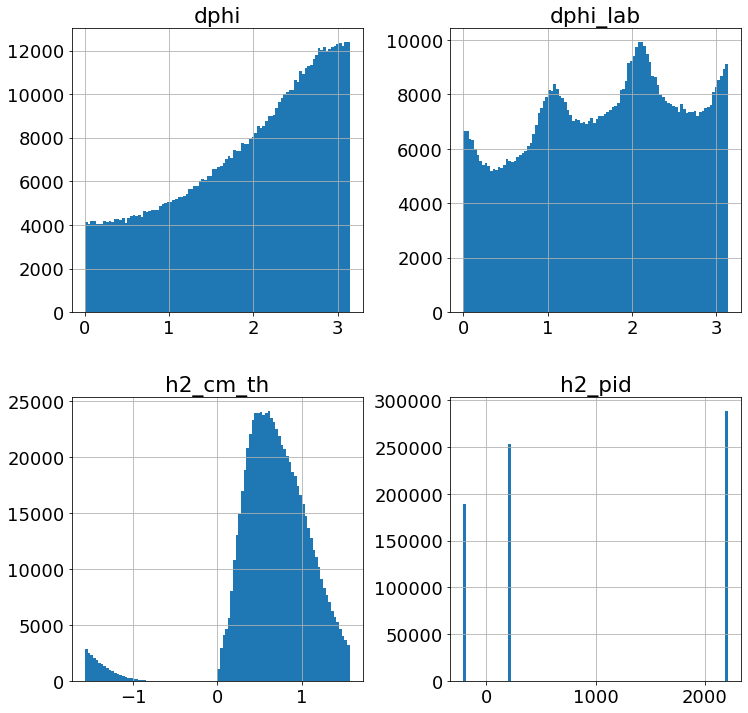

In [15]:
df['Fe'].hist(figsize=(12,12),bins=100,column=['dphi','dphi_lab','h2_cm_th','h2_pid'])
plt.show()

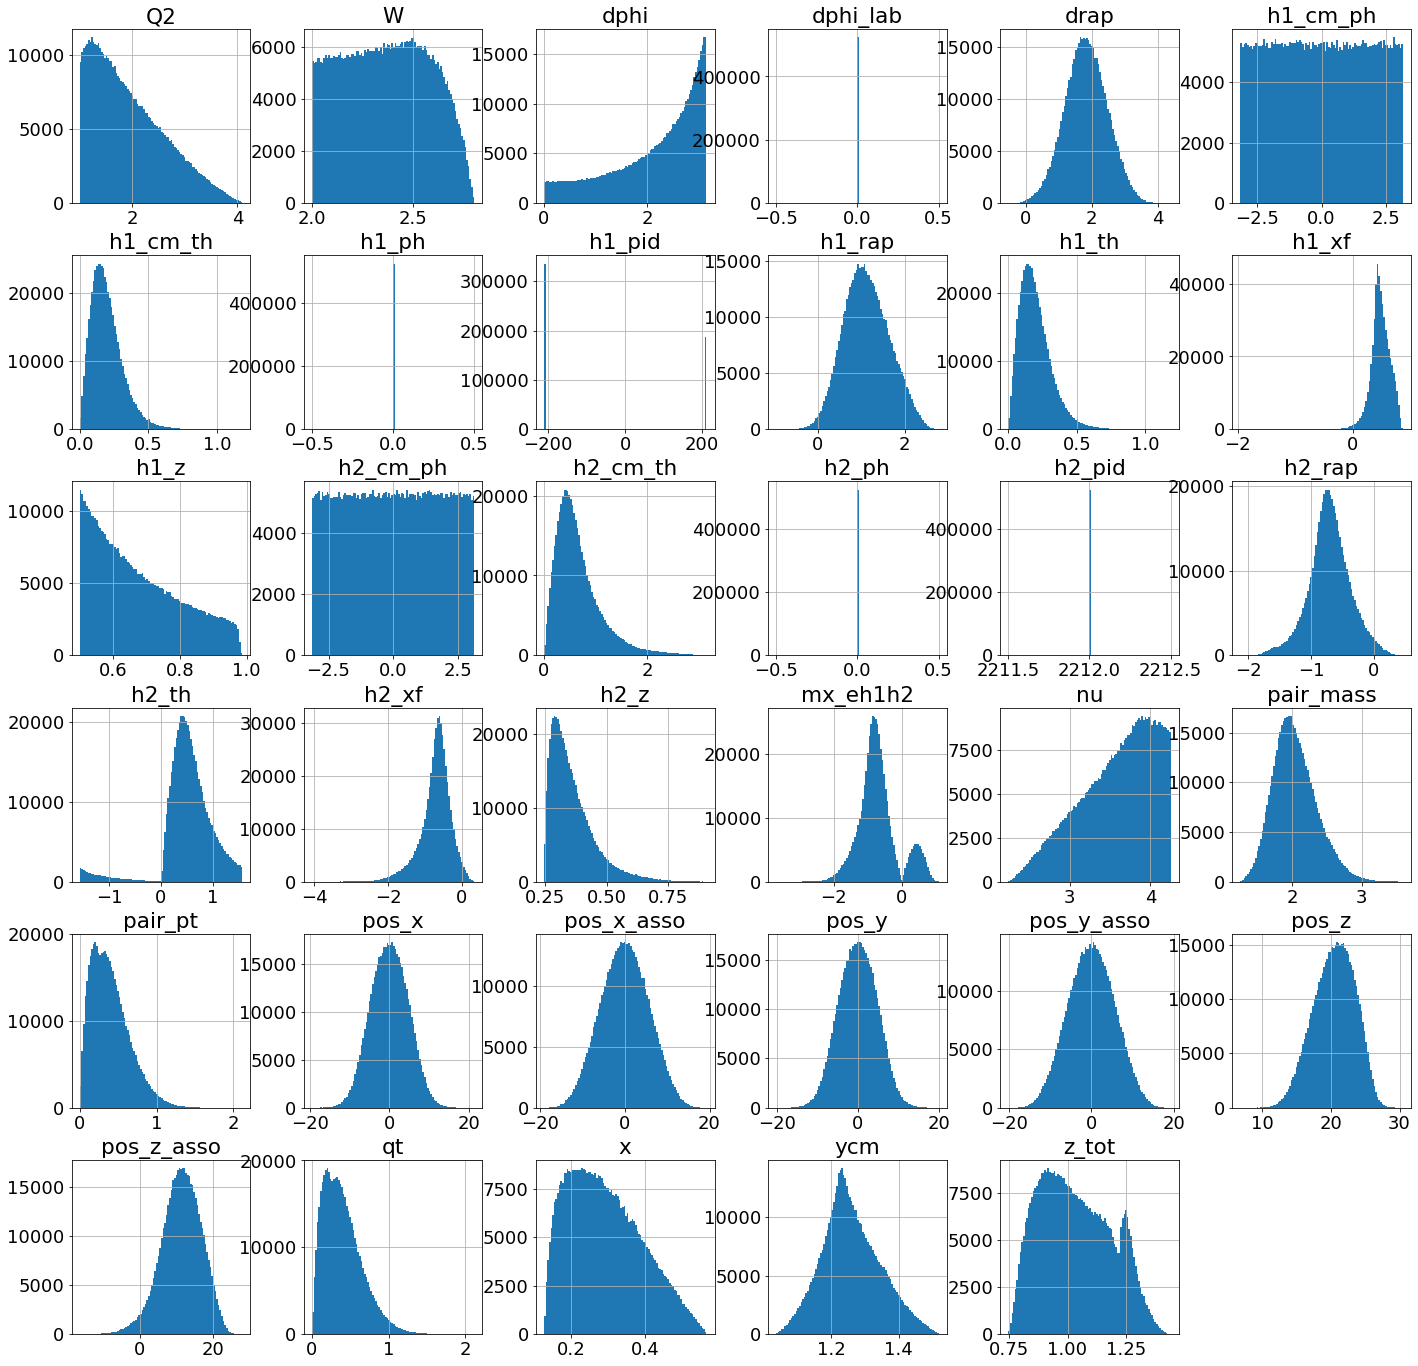

In [29]:
df['GiBUU_Pb'].query('h2_pid==2212').hist(figsize=(24,24),bins=100)
plt.yscale('log')
plt.show()

## Apply selection to datasets

In [30]:
#dataframees with pairs
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    
    print (key)
    
    df[key] = applyCuts(df[key],isMC=isMC)
    df[key] = applyCutsPair(df[key],isMC=isMC)


Fe
Entries before cut  732518
Q2>1.0 : 732518  (100.00  %)
h1_p<2.5  732518  (100.00  %)
inelasticity < 0.85 732518  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 732518  (100.00  %)
h1_z>0.5 : 732518  (100.00  %)
h1_p<2.5  732518  (100.00  %)
h2_pid =2212 or pions 732518  (100.00  %)
10< h2_th<120 732518  (100.00  %)
h2_p>0.200 732518  (100.00  %)
P>500 for pi- with theta<30 732518  (100.00  %)
h2_p <2.5 GeV 732518  (100.00  %)
D_Fe
Entries before cut  797153
Q2>1.0 : 797153  (100.00  %)
h1_p<2.5  797153  (100.00  %)
inelasticity < 0.85 797153  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 797153  (100.00  %)
h1_z>0.5 : 797153  (100.00  %)
h1_p<2.5  797153  (100.00  %)
h2_pid =2212 or pions 797153  (100.00  %)
10< h2_th<120 797153  (100.00  %)
h2_p>0.200 797153  (100.00  %)
P>500 for pi- with theta<30 797153  (100.00  %)
h2_p <2.5 GeV 797153  (100.00  %)
GiBUU_D
Entries before cut  2099630
Q2>1.0 : 2099630  (100.00  %)
h1_p<2.5  1295

## Apply selection to MC 

In [31]:
for key in df_mc.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    
    print (key)
    
    df_mc[key] = applyCuts(df_mc[key],isMC=isMC)
    df_mc[key] = applyCutsPair(df_mc[key],isMC=isMC)    
    
    df_mc[key] = applyCuts(df_mc[key],isMC=isMC)
    df_mc[key] = applyCutsPair(df_mc[key],isMC=isMC)
    

D
Entries before cut  183057
Q2>1.0 : 183057  (100.00  %)
h1_p<2.5  183057  (100.00  %)
inelasticity < 0.85 183057  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 183057  (100.00  %)
h1_z>0.5 : 183057  (100.00  %)
h1_p<2.5  183057  (100.00  %)
h2_pid =2212 or pions 183057  (100.00  %)
10< h2_th<120 183057  (100.00  %)
h2_p>0.200 183057  (100.00  %)
P>500 for pi- with theta<30 183057  (100.00  %)
h2_p <2.5 GeV 183057  (100.00  %)
Entries before cut  183057
Q2>1.0 : 183057  (100.00  %)
h1_p<2.5  183057  (100.00  %)
inelasticity < 0.85 183057  (100.00  %)
Starting election on dipion variables
This is Data
Q2>1.0 : 183057  (100.00  %)
h1_z>0.5 : 183057  (100.00  %)
h1_p<2.5  183057  (100.00  %)
h2_pid =2212 or pions 183057  (100.00  %)
10< h2_th<120 183057  (100.00  %)
h2_p>0.200 183057  (100.00  %)
P>500 for pi- with theta<30 183057  (100.00  %)
h2_p <2.5 GeV 183057  (100.00  %)
C
Entries before cut  177238
Q2>1.0 : 177238  (100.00  %)
h1_p<2.5  177238  (100.00  %

In [32]:
for key in df_trigger.keys():
    print (key)
    df_trigger[key] = applyCuts(df_trigger[key],isTrigger=True)
    print (' ') 

Fe_trigger
Entries before cut  2710143
Q2>1.0 : 2710143  (100.00  %)
h1_p<2.5  2710143  (100.00  %)
inelasticity < 0.85 2710143  (100.00  %)
 
D_Fe_trigger
Entries before cut  2860145
Q2>1.0 : 2860145  (100.00  %)
h1_p<2.5  2860145  (100.00  %)
inelasticity < 0.85 2860145  (100.00  %)
 
GiBUU_D_trigger
Entries before cut  2047709
Q2>1.0 : 2047709  (100.00  %)
h1_p<2.5  1052848  (51.42  %)
inelasticity < 0.85 1052848  (100.00  %)
 
GiBUU_C_trigger
Entries before cut  2011729
Q2>1.0 : 2011729  (100.00  %)
h1_p<2.5  1050741  (52.23  %)
inelasticity < 0.85 1050741  (100.00  %)
 
GiBUU_Fe_trigger
Entries before cut  874492
Q2>1.0 : 874492  (100.00  %)
h1_p<2.5  461435  (52.77  %)
inelasticity < 0.85 461435  (100.00  %)
 
GiBUU_Pb_trigger
Entries before cut  999262
Q2>1.0 : 999262  (100.00  %)
h1_p<2.5  538143  (53.85  %)
inelasticity < 0.85 538143  (100.00  %)
 
D_trigger
Entries before cut  2860145
Q2>1.0 : 2860145  (100.00  %)
h1_p<2.5  2860145  (100.00  %)
inelasticity < 0.85 2860145  (1

In [33]:
for key in df_mc_trigger.keys():
    print (key)
    df_mc_trigger[key] = applyCuts(df_mc_trigger[key],isTrigger=True)
    print (' ') 

D_trigger
Entries before cut  715190
Q2>1.0 : 715190  (100.00  %)
h1_p<2.5  715190  (100.00  %)
inelasticity < 0.85 715190  (100.00  %)
 
C_trigger
Entries before cut  705909
Q2>1.0 : 705909  (100.00  %)
h1_p<2.5  705909  (100.00  %)
inelasticity < 0.85 705909  (100.00  %)
 


In [ ]:
df['Fe'].query('h1_z>0.5').hist(figsize=(25, 25),alpha=0.5,bins=100)
plt.show()

## R_2h data from HERMES and Neutrino buble-chamber experiment

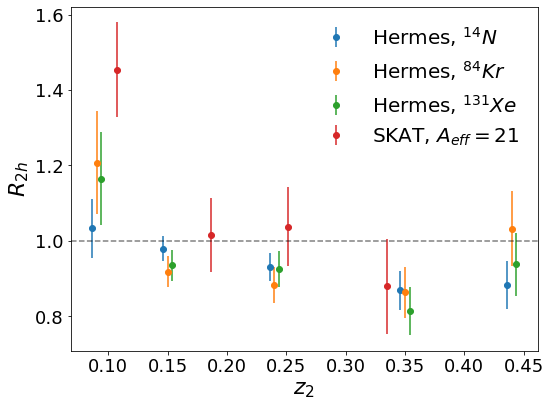

In [34]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.004)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.004)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))


neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))



plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('$z_{2}$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('PreviousData.png')
plt.savefig('PreviousData_R2h.pdf')

plt.show()

In [35]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05)
    plt.errorbar(x+0.01*i,r,yerr=err,label='This work,  %s'%target,fmt='o',ms=8)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',label='HERMES, $N$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',label='HERMES, $Kr$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',label='HERMES, $Xe$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

#plt.ylim([0.5,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=2)

plt.tight_layout()
plt.savefig('ComparisonWithHermes_Linear.png')
#plt.xlim([0.05,0.5])

#plt.xscale('log')
#plt.savefig('ComparisonWithHermes_Log.png')

plt.show()

KeyError: 'C'

<Figure size 576x432 with 0 Axes>

## Get ratio from MC (null expected). Deviations reflect acceptance differences between solid and liquid target

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h1_pid>0 and h2_pid<0
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h1_pid<0 and h2_pid>0


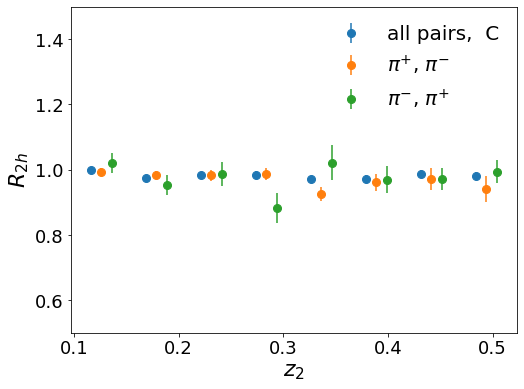

In [36]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C']):
    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08)
    
    plt.errorbar(x+0.01,r,yerr=err,label='all pairs,  %s'%target,fmt='o',ms=8)
    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08,    pair_cut='and h1_pid>0 and h2_pid<0')
    plt.errorbar(x+0.02,r,yerr=err,label='$\pi^{+}$, $\pi^{-}$',fmt='o',ms=8)
    
    
    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08,    pair_cut='and h1_pid<0 and h2_pid>0')
    plt.errorbar(x+0.03,r,yerr=err,label='$\pi^{-}$, $\pi^{+}$',fmt='o',ms=8)
    
plt.ylabel(r'$R_{2h}$',fontsize=22)
plt.xlabel(r'$z_{2}$',fontsize=22)
plt.ylim([0.5,1.5])
plt.legend(frameon=False,loc='best')

## Theory only GiBUU

In [ ]:
df['GiBUU_C'].keys()

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212


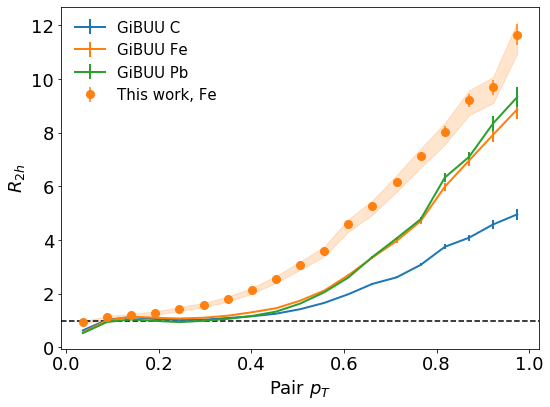

In [37]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
for target in ['Fe']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
plt.xlabel('Pair $p_{T}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

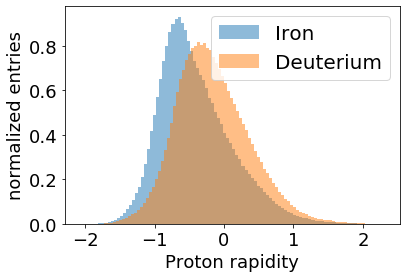

In [47]:

plt.hist(df['Fe']['h2_rap'],bins=100,alpha=0.5,density=True,label='Iron')
plt.hist(df['D']['h2_rap'],bins=100,alpha=0.5,density=True,label='Deuterium')
plt.xlabel('Proton rapidity')
plt.ylabel('normalized entries')
plt.legend()
plt.show()

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212


<ipython-input-2-b53e2b004ee4>:18: RuntimeWarning: invalid value encountered in true_divide
  err_A = np.true_divide(np.sqrt(erry_A),y_A)
<ipython-input-2-b53e2b004ee4>:19: RuntimeWarning: invalid value encountered in true_divide
  err_D = np.true_divide(np.sqrt(erry_D),y_D)
<ipython-input-2-b53e2b004ee4>:22: RuntimeWarning: invalid value encountered in true_divide
  ratio_conditional = np.true_divide(y_A,y_D)


Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212


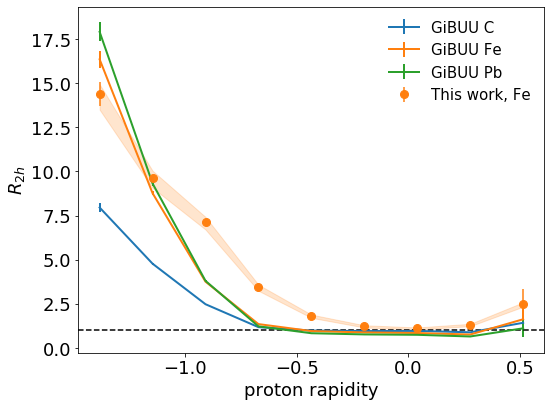

In [48]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and abs(h2_pid)==2212',minz=-1.5,maxz=3.0,nbins=20,variable='h2_rap')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)

    
for target in ['Fe']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                       pair_cut='and abs(h2_pid)==2212',minz=-1.5,maxz=3.0,nbins=20,variable='h2_rap')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
plt.xlabel('proton rapidity',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.yscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

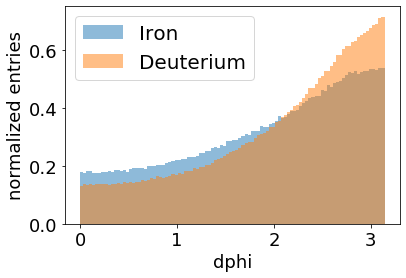

In [52]:

plt.hist(df['Fe']['dphi'],bins=100,alpha=0.5,density=True,label='Iron')
plt.hist(df['D']['dphi'],bins=100,alpha=0.5,density=True,label='Deuterium')
plt.xlabel('dphi')
plt.ylabel('normalized entries')
plt.legend()
plt.show()

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0


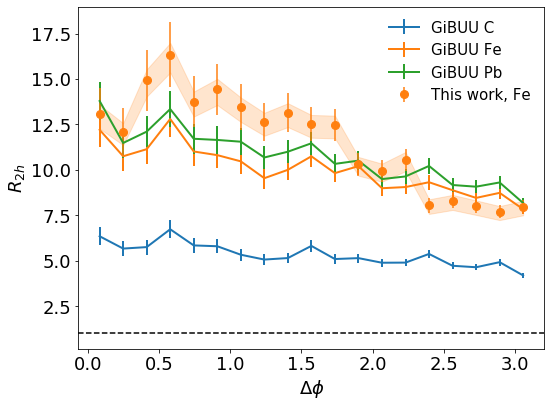

In [55]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0',minz=0.0,maxz=3.14,nbins=20,variable='dphi')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
for target in ['Fe']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0',minz=0.0,maxz=3.14,nbins=20,variable='dphi')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
plt.xlabel('$\Delta\phi$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.yscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5and h2_pid==2212


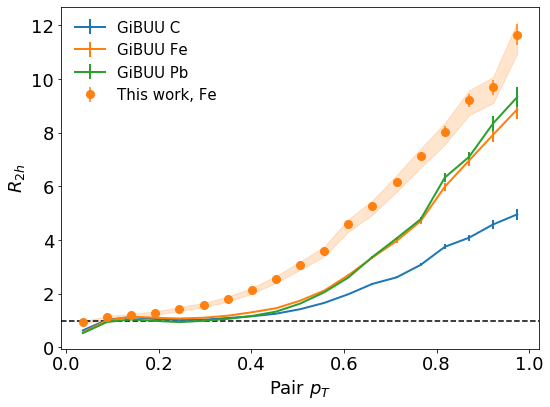

In [53]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
for target in ['Fe']:
    
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

plt.xlabel('Pair $p_{T}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

In [ ]:
df['C'].keys()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.offsetbox import AnchoredText

from mpl_toolkits.mplot3d.axes3d import get_test_data

def dphi_deta_plot(df,df_trig,deta_range=(-2,6),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    x = df.drap
    y = df.dphi
    if fig == None:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[deta_range, dphi_range])
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist = np.divide(hist, denom)
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax.plot_surface(xpos, ypos, hist.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax.set_xlabel("$\\Delta y$")
    ax.set_ylabel("$\\Delta\\phi$")
    ax.set_zlabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=-90)
    ax.set_xlim(*deta_range)
    ax.set_ylim(*dphi_range)
    return fig,ax
df_temp = df['C'].query("h1_z>0.5"\
                         + "and abs(h2_pid) == 211")
df_trig_temp = df_trigger['C_trigger'].query("h1_z>0.5")
fig,ax = dphi_deta_plot(df_temp,df_trig_temp,
              deta_range=(0,5))
plt.gca().add_artist(AnchoredText("$\pi^+p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
#plt.savefig("../images/dphi_vs_deta_pip_p.pdf",bbox_inches='tight')
plt.show()

In [ ]:
df_temp = df['Pb'].query("h1_z>0.5"\
                         + "and abs(h2_pid) == 211")
df_trig_temp = df_trigger['Pb_trigger'].query("h1_z>0.5")
fig,ax = dphi_deta_plot(df_temp,df_trig_temp,
              deta_range=(0,5))
plt.gca().add_artist(AnchoredText("$\pi^+p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
#plt.savefig("../images/dphi_vs_deta_pip_p.pdf",bbox_inches='tight')
plt.show()

## Result compared with GiBUU

In [ ]:
fig = plt.figure(figsize=(8,6))



for i,target in enumerate(['Fe','Pb']):
    #data
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.05,maxz=0.5
                       )
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
    
    #gibuu
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=0.05,maxz=0.5, applyweight=False, pair_cut = ' and abs(h2_pid)==211'
                       )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])

#plt.xscale('log')
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


#plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',label='Hermes, N',fillstyle=None,ms=8,capsize=5,color='grey')
#plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',label='Hermes, Kr',fillstyle=None,ms=8,capsize=5,color='brown')
#plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',label='Hermes, Xe',fillstyle=None,ms=8,capsize=5,color='darkviolet')
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.text(0.20, 1.2, 'CLAS \nINTERNAL', fontsize=30)

plt.legend(frameon=False,ncol=2,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')


In [ ]:
fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['C','Fe','Pb']):
    #data
    
  
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.07,maxz=0.5,applyweight=False
                       )
    plt.errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])

   
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)

plt.legend(frameon=False,ncol=3,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')


In [ ]:
x_data = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
y_data = {}
erry_data  ={}

y_data['pip_C'] = np.array([1.16751 , 1.01848 , 0.926135 , 0.876012 , 0.8595 , 0.848906 , 0.832911 , 0.762776 , 0.782656 , 0.698996 ])
erry_data['pip_C'] = np.array([0.00321583 , 0.00161351 , 0.00188183 , 0.00233672 , 0.00297862 , 0.00369811 , 0.00445801 , 0.00520291 , 0.00703654 , 0.00844543])
y_data['pip_Fe'] = np.array([1.18002 , 0.931569 , 0.772485 , 0.695442 , 0.653029 , 0.636352 , 0.609999 , 0.549825 , 0.538038 , 0.440439])
erry_data['pip_Fe'] = np.array([0.00297786 , 0.00136259 , 0.00146705 , 0.00175402 , 0.00214668 , 0.00261719 , 0.00307546 , 0.00352656 , 0.00457231 , 0.00516023])
y_data['pip_Pb'] = np.array([0.980339 , 0.747191 , 0.597805 , 0.522714 , 0.4807 , 0.466481 , 0.446264 , 0.399832 , 0.386629 , 0.277573 ])
erry_data['pip_Pb'] = np.array([0.0028235 , 0.00128281 , 0.00136618 , 0.00163387 , 0.00199655 , 0.0024583 , 0.00293294 , 0.00343855 , 0.00452875 , 0.0049117])



fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['C','Fe','Pb']):
    #data
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.07,maxz=0.5,applyweight=False
                       )
    plt.errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    plt.errorbar(x_data,y_data['pip_%s'%target],yerr=erry_data['pip_%s'%target],color=colors[target],fmt='s-',label=target)

    #gibuu
    #r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
    #                   ,variable='z_asso',minz=0.07,maxz=0.5#,pair_cut='and z_asso>0.1'
    #                   )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])

    plt
#plt.xscale('log')
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.xlim([0.0,0.5])

plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


In [ ]:
fig = plt.figure(figsize=(16,12))


label = {} 
label['C'] = '$^{12}C$'
label['Fe'] = '$^{56}Fe$'
label['Pb'] = '$^{208}Pb$'


colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

colors['C_pip'] = '#ff7f0e'
colors['Fe_pip'] = '#d62728'
colors['Pb_pip']=  '#8c564b'


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(16,6),gridspec_kw={'hspace': 0, 'wspace':0})

for i,target in enumerate(['C','Fe','Pb']):

    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.05,maxz=0.5,applyweight=False
                       )
    axs[i].errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='conditional',ms=8,fmt='o',alpha=0.8,color=colors[target])
    axs[i].fill_between(x, 1.04*r,0.96*r,alpha=0.2,color=colors[target])
   


    axs[i].set_xlim([0.0,0.5])

    axs[i].errorbar(x_data,y_data['pip_%s'%target],yerr=erry_data['pip_%s'%target],color='black',fmt='s',ms=8,alpha=0.7,label='inclusive')
    axs[i].fill_between(x_data, 1.03*y_data['pip_%s'%target],0.97*y_data['pip_%s'%target],color='black',alpha=0.2)

    
    axs[i].legend(loc='lower left',ncol=1,frameon=False,fontsize=19)
    axs[i].xaxis.set_label_text('$z$',fontsize=22)

axs[0].set_title('$^{}C$',fontsize=22)
axs[1].set_title('$^{}Fe$',fontsize=22)
axs[2].set_title('$^{}Pb$',fontsize=22)
axs[0].yaxis.set_label_text('Suppression factor',fontsize=22)


## Results vs GiBUU (mass)

In [ ]:
fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='pair_mass',minz=0.4,maxz=2.0,nbins=11,pair_cut='and h2_z>0.10',applyweight=False
                       )
    plt.errorbar(x+0.02*i,r,yerr=err,label='%s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='pair_mass',minz=0.4,maxz=2.0,nbins=11,pair_cut='and h2_z>0.10',applyweight=False
                       )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    plt.plot(x+0.02*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=False,ncol=2,loc='upper left')
plt.xlabel('Dipion mass (GeV)',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)

#plt.ylim([0.0,1.2])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_mass.png')
plt.savefig('MainResult_withGiBUU_mass.pdf')

## Compare results with and without z_tot<0.8 cut

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='h2_z')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'],applyweight=False
                          )
    axs[0].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)

    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='h2_z',pair_cut=' and z_tot<0.8')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',mfc='white',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                         pair_cut=' and z_tot<0.80',applyweight=False)
    axs[1].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)
    
    
axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[0].axhline(y=1.0,color='black',linestyle='--')

axs[1].set_title('with $z_1+z_2<$0.8', fontsize=13)
axs[0].set_title('no cut ', fontsize=13)

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.savefig('ExclusiveCutVariation.png')
plt.show()

## Checking the dependency of the ratios on varios things like the charged of leading pion, subleading pion; Q2 and Nu

In [ ]:

for target in ['C','Fe','Pb']:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})
  
    ##Negative associated hadron
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='h1_pid>0', pair_cut='and h2_pid<0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, +/-'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target], trig_cut = 'h1_pid<0',pair_cut='and h2_pid>0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, -/+'%target,fmt='o',ms=8,lw=3,capsize=5)



    ##GiBUU negative trigger
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'],trig_cut='h1_pid>0',  pair_cut='and h2_pid<0',applyweight=False)                                              
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi- asso'%target,ms=8,lw=3,capsize=5)

    
    
    ##GiBUU positive trigger
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'],trig_cut='h1_pid<0', pair_cut='and h2_pid>0',applyweight=False)                                              
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi+ asso'%target,ms=8,lw=3,capsize=5)
    
    ##GiBUU all hadrons
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'])                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, all'%target,ms=8,lw=3,capsize=5)
    


    axs[1].axhline(y=1.0,color='black',linestyle='--')
    axs[0].axhline(y=1.0,color='black',linestyle='--')

    axs[0].legend(frameon=False)
    axs[1].legend(frameon=False)


    plt.savefig('ConsistencyCharge_%s.png'%target)
    plt.show()
    plt.clf()

## R_2h as a function of theta

In [ ]:
plt.hist(df['C'].query('h1_pid>0')['h2_th'],bins=100,alpha=0.5,label='positive trigger')
plt.hist(df['C'].query('h1_pid<0')['h2_th'],bins=100,alpha=0.5,label='negative trigger')
plt.legend()
plt.xlabel('theta lab asso')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [25,40,55,80]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for target in ['Fe']:
    for j, ibin in enumerate(bins):

        pair_cut = 'and h2_th>%2.2f and h2_th<=%2.2f'%(ibin[0],ibin[1])
        label = '%2.0f$<\Theta<$%2.0f, D'%(ibin[0],ibin[1])

    
    ##Positive trigger
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='h1_pid>0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[0].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
        ##negative trigger
        
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='h1_pid<0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[1].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
axs[0].legend(frameon=False,fontsize=12,ncol=2)
axs[1].legend(frameon=False,fontsize=12,ncol=1)    




## z2 distribution breakdown for pi+ and pi- for all nuclei

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df[target].query('h1_z>0.5 and h2_pid>0')['h2_z'], bins=100,range =(0,0.5),label='$\pi^+$',alpha=0.5)
    plt.hist(df[target].query('h1_z>0.5 and h2_pid<0')['h2_z'], bins=100,range =(0,0.5),label='$\pi^-$',alpha=0.5)

    plt.title('%s, Conditional for $z_{1}>0.5$'%target)
    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{2}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('ConditionalDistribution_z2_BothPions.png')

# z distribution of triggers by charge

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df_trigger['%s_trigger'%target].query('h1_z>0.5 and h1_pid>0')['h1_z'], bins=100,range =(0.5,1.0),label='$\pi^+$',alpha=0.5)
    plt.hist(df_trigger['%s_trigger'%target].query('h1_z>0.5 and h1_pid<0')['h1_z'], bins=100,range =(0.5,1.0),label='$\pi^-$',alpha=0.5)

    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{1}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('Triggers.png')

## Distributions


In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['h2_p'],bins=50,density=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['h2_p'],bins=50,density=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['nu'],bins=50,density=True,range=(2.0,5.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['nu'],bins=50,density=True,range=(2.0,5.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Nu (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Nu (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['Q2'],bins=50,density=True,range=(1.0,4.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['Q2'],bins=50,density=True,range=(1.0,4.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)
axs[1].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['z_tot'],bins=50,density=True,range=(0.5,1.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['z_tot'],bins=50,density=True,range=(0.5,1.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$z_{tot}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{tot}$',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['pair_mass'],bins=50,density=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['pair_mass'],bins=50,density=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
for target in ['C','Fe','Pb']:
    y, x = np.histogram(df_trigger['%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0))
    y_D, x = np.histogram(df_trigger['D_%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0))
    x = (x[:-1] + x[1:])/2.0
    ratio = np.true_divide(y,y_D)
    plt.plot(x,ratio,label=target)

plt.xlabel('z')
plt.ylabel('ratio to deuterium')
plt.legend(frameon=False)
plt.show()
plt.savefig('Triggers_z1distributions_RatioToD.png')

In [ ]:
fig = plt.figure( figsize=(18, 4))

for i, target in enumerate(['C','Fe','Pb']):
    plt.subplot(1,3,i+1)
    plt.hist(df_trigger['%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0),histtype='step', label=target)
    plt.hist(df_trigger['D_%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0),histtype='step',label='D (%s)'%target)

    plt.ylabel('Number of pions',fontsize=13)
    plt.xlabel('$z_{1}$',fontsize=13)
    plt.legend(frameon=False)    

plt.savefig('Triggers_z1distributions.png')

In [ ]:
plt.hexbin(df_trigger['D_trigger']['Q2'],df_trigger['D_trigger']['nu'], cmap='inferno')


In [ ]:
plt.hexbin(df_trigger['GiBUU_D_trigger']['Q2'],df_trigger['GiBUU_D_trigger']['nu'],cmap='inferno')


In [ ]:
df['D'].hist(figsize=(12,12),bins=100)
plt.show()

In [ ]:
plt.hist(df['D']['pair_pt'],bins=100,density=True,alpha=0.3,label='D')
plt.hist(df['Pb']['pair_pt'],bins=100,density=True,alpha=0.3)
plt.legend()

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,sharex=True, sharey=True,figsize=(16,6),gridspec_kw={'hspace': 0, 'wspace':0})
temp = df['D'].query('h1_pid==-211')
axs[0].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')
temp = df['D'].query('h1_pid==+211')
axs[1].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')


In [ ]:
fig, axs = plt.subplots(2, 2,sharex=True, sharey=True,figsize=(16,12),gridspec_kw={'hspace': 0, 'wspace':0})
temp = df['Fe'].query('h1_pid==-211')
axs[1,0].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[1,1].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==-211')
axs[0,0].hexbin(temp['h1_z'], temp['h1_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[0,1].hexbin(temp['h1_z'], temp['h1_th'],cmap ='inferno')

axs[1,0].xaxis.set_label_text('z',fontsize=18)
axs[1,1].xaxis.set_label_text('z',fontsize=18)
axs[0,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)
axs[1,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)

axs[0,0].set_title('$\pi^{-}$ trigger' ,fontsize=22)
axs[0,1].set_title('$\pi^{+}$ trigger',fontsize=22)

In [ ]:
fig, axs = plt.subplots(2, 2,sharex=True, sharey=True,figsize=(16,12),gridspec_kw={'hspace': 0, 'wspace':0})
temp = df['Fe'].query('h1_pid==-211')
axs[1,0].hexbin(temp['h2_p'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[1,1].hexbin(temp['h2_p'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==-211')
axs[0,0].hexbin(temp['h2_p'], temp['h1_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[0,1].hexbin(temp['h2_p'], temp['h1_th'],cmap ='inferno')

axs[1,0].xaxis.set_label_text('Momentum [GeV]',fontsize=18)
axs[1,1].xaxis.set_label_text('Momentum [GeV]',fontsize=18)
axs[0,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)
axs[1,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)

axs[0,0].set_title('$\pi^{-}$ trigger' ,fontsize=22)
axs[0,1].set_title('$\pi^{+}$ trigger',fontsize=22)

In [ ]:
df['Fe'].keys()